In [30]:
%matplotlib inline
import os
import sys
import matplotlib

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
import cmath
import pickle
import time
from collections import defaultdict
import sklearn

from datetime import datetime, date

from sktensor import dtensor, cp_als
# matplotlib.style.use('ggplot')

from sklearn.utils.extmath import randomized_svd
from sklearn.metrics import precision_recall_curve, average_precision_score
from sktensor import dtensor, cp_als


from numpy import linalg as LA

matplotlib.style.use('ggplot')

### Create the tensor

In [31]:
df = pickle.load( open( "dblp_inproceeding_10.p", "rb" ) )
df = df[df.crossref != '']
df.shape

(1296663, 3)

In [32]:
#selected_index = np.random.choice(len(df), int(0.5*len(df)))
#df = df.iloc[selected_index, :]

In [18]:
AUC_CUT_TSVD = []
AUC_CWT_TSVD = []
AUC_CUT_BKatz = []
AUC_CWT_BKatz = []
AUC_CUT_TBKatz = []
AUC_CWT_TBKatz = []

### Choose only 10 years

In [41]:
val = 6  

print 'Step 1'
df_train = df[df.year>=1991+val]
df_train = df[df.year<=2000+val]
df_test = df[df.year==2001+val]

df_train.reset_index(inplace=True)
df2 = df_train.iloc[:,1:]
df_train = df2
del df2

df_train = df_train[df_train.crossref != '']
df_train.reset_index(inplace=True)
df2 = df_train.iloc[:,1:]
df_train = df2
del df2

author_list = pd.unique(df_train.iloc[:,0])

# Get the indexes of each author
authors_indexes = [(element, index) for index, element in enumerate(df_train.author)]
author_index = defaultdict(list)

for k, v in authors_indexes:
    author_index[k].append(v)

# Keep the authors with more than 10 publications
author_index_sorted = []
count = 0

print 'Step 2'

for author in author_list : 
    if len(author_index[author]) > 10 :
        author_index_sorted += author_index[author]
        count += len(author_index[author])

df_train = df_train[df_train.index.isin(author_index_sorted)]
df_test = df_test[df_test.author.isin(df_train.author)]
df_test = df_test[df_test.crossref.isin(df_train.crossref)]
df_train.shape, df_test.shape

author_list = pd.unique(df_train.iloc[:, 0])
conf_list = pd.unique(df_train.iloc[:, 2])
year_list = pd.unique(df_train.iloc[:, 1])
year_list.sort()

author_dic = {element : index for index, element in enumerate(author_list)}
conf_dic =   {element : index for index, element in enumerate(conf_list)}
year_dic =   {element : index for index, element in enumerate(year_list)}

T_train = np.zeros((len(author_list), len(conf_list), len(year_list)))
T_train = dtensor(T_train)

# Going through the dataframe
for a, c, y in zip(df_train.author, df_train.crossref, df_train.year):        
    # Finding the corresponding index in the tensor
    a_ind = author_dic[a]
    c_ind = conf_dic[c]
    y_ind = year_dic[y]
    # Modifying the tensor value for the tuple (i_ind, j_ind, k_ind)
    T_train[a_ind, c_ind, y_ind] += 1

# Logarithmic Transformation
nonz = T_train.nonzero()
for ind in range(len(nonz[0])):
    i_ind = nonz[0][ind]
    j_ind = nonz[1][ind] 
    k_ind = nonz[2][ind]  
    T_train[i_ind, j_ind, k_ind] = 1 + np.log(T_train[i_ind, j_ind, k_ind]) 

print 'Step 3'
author_list_train = author_list
conf_list_train = conf_list
author_dic_train = author_dic
conf_dic_train = conf_dic

T_test = np.zeros((len(author_list_train), len(conf_list_train)))

# Going through the dataframe
for a, c in zip(df_test.author, df_test.crossref):
    # Finding the corresponding index in the tensor
    a_ind = author_dic_train[a]
    c_ind = conf_dic_train[c]
    # Modifying the tensor value for the tuple (i_ind, j_ind, k_ind)
    T_test[a_ind, c_ind] = 1

del author_list_train, conf_list_train, author_list, conf_list, author_dic, conf_dic, df_test

#Proportion of non-zero entries of the tensor
mail_rate = np.count_nonzero(T_train) / float(T_train.shape[0] * T_train.shape[1] * T_train.shape[2])

print 'Step 4'
# CUT
CUT = np.zeros((T_train[:,:,0].shape[0], T_train[:,:,0].shape[1]))
for k in range(T_train.shape[2]):
    CUT = CUT + T_train[:,:,k]

# TSVD
S_test = (1*np.array(T_test[:, :] >= 1))
S = np.zeros((CUT.shape[0], CUT.shape[1]))
tau = 2
K_list = [1,5,10,30,50]
for i in range(2) :
    if i==0 :
        for K_ind in range(len(K_list)):
            # Choice of K
            K = K_list[K_ind]
            # TSVD Decomposition
            U, Sigma, Vt = randomized_svd(CUT, n_components=K, n_iter=5, random_state=None)
            # TSVD Scoring
            Sk = np.dot(np.dot(U,np.diag(Sigma)),Vt)
            S+= Sk/LA.norm(Sk, 'fro')
        y_score = S.flatten()
        y_test = S_test.flatten()
    else :
        nonz = CUT.nonzero()
        for ind in range(len(nonz[0])):
            i_ind = nonz[0][ind]
            j_ind = nonz[1][ind] 
            S[i_ind, j_ind] = 0
        y_score2 = S.flatten()
        y_test2 = S_test.flatten()
AUC_CUT_TSVD += [(sklearn.metrics.roc_auc_score(y_test, y_score),sklearn.metrics.roc_auc_score(y_test2, y_score2))]

print 'Step 5'

# BKatz
beta = 0.001
U, Sigma, V= np.linalg.svd(CUT, full_matrices=False)
S_test = (1*np.array(T_test[:, :] >= 1))
theta = 0.2
for i in range(2) :
    gamma = []
    for j in range(len(Sigma)) :
        gamma += [1/(1-beta*Sigma[j]) - 1]
    # Katz Scoring
    S = np.dot(np.dot(U,np.diag(gamma)),V)
    if i == 0 :
        y_score = S.flatten()
        y_test = S_test.flatten()
    else :
        nonz = CUT.nonzero()
        for ind in range(len(nonz[0])):
            i_ind = nonz[0][ind]
            j_ind = nonz[1][ind] 
            S[i_ind, j_ind] = 0
        y_score2 = S.flatten()
        y_test2 = S_test.flatten()
AUC_CUT_BKatz += [(sklearn.metrics.roc_auc_score(y_test, y_score),sklearn.metrics.roc_auc_score(y_test2, y_score2))]

print 'Step 6'
#TBKatz
beta = 0.001
S_test = (1*np.array(T_test[:, :] >= 1))
K_list = [1,5,10,30,50]

for i in range(2) :
    for K_ind in range(len(K_list)) :
        K=K_list[K_ind]
        U, Sigma, Vt= randomized_svd(CUT, n_components=K, n_iter=5, random_state=None)
        gamma = []
        for j in range(K) :
            gamma += [1/(1-beta*Sigma[j]) - 1]
        Sk = np.dot(U,np.dot(np.diag(gamma), Vt))
        S+= Sk/LA.norm(Sk, 'fro')
    if i == 0 :
        y_score = S.flatten()
        y_test = S_test.flatten()
    else :
        nonz = CUT.nonzero()
        for ind in range(len(nonz[0])):
            i_ind = nonz[0][ind]
            j_ind = nonz[1][ind] 
            S[i_ind, j_ind] = 0
        y_score2 = S.flatten()
        y_test2 = S_test.flatten() 
AUC_CUT_TBKatz += [(sklearn.metrics.roc_auc_score(y_test, y_score),sklearn.metrics.roc_auc_score(y_test2, y_score2))]


print 'Step 7'
# CWT
CWT = np.zeros((T_train[:,:,0].shape[0], T_train[:,:,0].shape[1]))
theta = 0.2
K = T_train.shape[2]
for k in range(T_train.shape[2]):
    CwT = CWT + ((1-theta)**(K - k))*T_train[:,:,k]
# Create a np.array matrix instead of the sklearn tensor
C = np.zeros((T_train[:,:,0].shape[0], T_train[:,:,0].shape[1]))
for i in range(CWT.shape[0]) :
    for j in range(CWT.shape[1]) :
        C[i,j] = CWT[i,j]
CWT = C
del C

print 'Step 8'
# TSVD
S_test = (1*np.array(T_test[:, :] >= 1))
S = np.zeros((CWT.shape[0], CWT.shape[1]))
tau = 2
K_list = [1,5,10,30,50]
for i in range(2) :
    if i==0 :
        for K_ind in range(len(K_list)):
            # Choice of K
            K = K_list[K_ind]
            # TSVD Decomposition
            U, Sigma, Vt = randomized_svd(CWT, n_components=K, n_iter=5, random_state=None)
            # TSVD Scoring
            Sk = np.dot(np.dot(U,np.diag(Sigma)),Vt)
            S+= Sk/LA.norm(Sk, 'fro')
        y_score = S.flatten()
        y_test = S_test.flatten()
    else :
        nonz = CWT.nonzero()
        for ind in range(len(nonz[0])):
            i_ind = nonz[0][ind]
            j_ind = nonz[1][ind] 
            S[i_ind, j_ind] = 0
        y_score2 = S.flatten()
        y_test2 = S_test.flatten()
AUC_CWT_TSVD += [(sklearn.metrics.roc_auc_score(y_test, y_score),sklearn.metrics.roc_auc_score(y_test2, y_score2))]

print 'Step 9'
# BKatz
beta = 0.001
U, Sigma, V= np.linalg.svd(CWT, full_matrices=False)
S_test = (1*np.array(T_test[:, :] >= 1))
theta = 0.2
for i in range(2) :
    gamma = []
    for j in range(len(Sigma)) :
        gamma += [1/(1-beta*Sigma[j]) - 1]
    # Katz Scoring
    S = np.dot(np.dot(U,np.diag(gamma)),V)
    if i == 0 :
        y_score = S.flatten()
        y_test = S_test.flatten()
    else :
        nonz = CWT.nonzero()
        for ind in range(len(nonz[0])):
            i_ind = nonz[0][ind]
            j_ind = nonz[1][ind] 
            S[i_ind, j_ind] = 0
        y_score2 = S.flatten()
        y_test2 = S_test.flatten()
AUC_CWT_BKatz += [(sklearn.metrics.roc_auc_score(y_test, y_score),sklearn.metrics.roc_auc_score(y_test2, y_score2))]

print 'Step 10'
#TBKatz
beta = 0.001
S_test = (1*np.array(T_test[:, :] >= 1))
K_list = [1,5,10,30,50]

for i in range(2) :
    for K_ind in range(len(K_list)) :
        K=K_list[K_ind]
        U, Sigma, Vt= randomized_svd(CWT, n_components=K, n_iter=5, random_state=None)
        gamma = []
        for j in range(K) :
            gamma += [1/(1-beta*Sigma[j]) - 1]
        Sk = np.dot(U,np.dot(np.diag(gamma), Vt))
        S+= Sk/LA.norm(Sk, 'fro')
    if i == 0 :
        y_score = S.flatten()
        y_test = S_test.flatten()
    else :
        nonz = CWT.nonzero()
        for ind in range(len(nonz[0])):
            i_ind = nonz[0][ind]
            j_ind = nonz[1][ind] 
            S[i_ind, j_ind] = 0
        y_score2 = S.flatten()
        y_test2 = S_test.flatten() 
AUC_CWT_TBKatz += [(sklearn.metrics.roc_auc_score(y_test, y_score),sklearn.metrics.roc_auc_score(y_test2, y_score2))]

print 'Done'

Step 1
Step 2
Step 3
Step 4
Step 5
Step 6
Step 7
Step 8
Step 9
Step 10
Done


In [42]:
print AUC_CUT_TSVD, AUC_CWT_TSVD, AUC_CUT_BKatz, AUC_CWT_BKatz, AUC_CUT_TBKatz, AUC_CWT_TBKatz

[(0.76372163213971456, 0.56689611372707616), (0.74923922498964401, 0.56479981923324096), (0.72986765013973531, 0.56021279186531536), (0.70357262151939282, 0.55238083018168493), (0.68125352682148332, 0.54480412217300944), (0.68451272397253538, 0.54395278448171058), (0.66705126779346613, 0.53821494225112387)] [(0.47957854046264192, 0.47957854046264192), (0.46361026621299817, 0.46361026621299817), (0.45045861984077595, 0.45045861984077595), (0.4415306681009068, 0.4415306681009068), (0.43139482314362221, 0.43139482314362221), (0.42682815903851912, 0.42682815903851912), (0.41784488264103975, 0.41784488264103975)] [(0.77698901028984046, 0.51053237618014868), (0.77562980873144438, 0.51162991829870352), (0.76617472065196657, 0.51107973991397015), (0.75448040991287968, 0.51046416874317657), (0.75010495358216733, 0.5093583032771567), (0.75313372362489062, 0.51147329987515444), (0.75821032513547448, 0.51173479612488892)] [(0.5, 0.5), (0.5, 0.5), (0.5, 0.5), (0.5, 0.5), (0.5, 0.5), (0.5, 0.5), (0.

### CanDecom/ParaFac (CP) Decomposition

In [23]:
# Defining a function for the outer product of several vectors
def Outer(vecs):
    # vecs can be either a list of vectors (n vectors of dimensions (**,1)) or an array of dimensions (**, n)
    vec_list = []
    if isinstance(vecs, list):
        vec_list = vecs
    elif isinstance(vecs, np.ndarray):
        vec_list = [vecs[:, j] for j in range(vecs.shape[1])]        

    res = reduce(np.multiply, np.ix_(*vec_list))
    return res

### Collapsed Unweighted Tensor  
Precision-Recall for several values of K

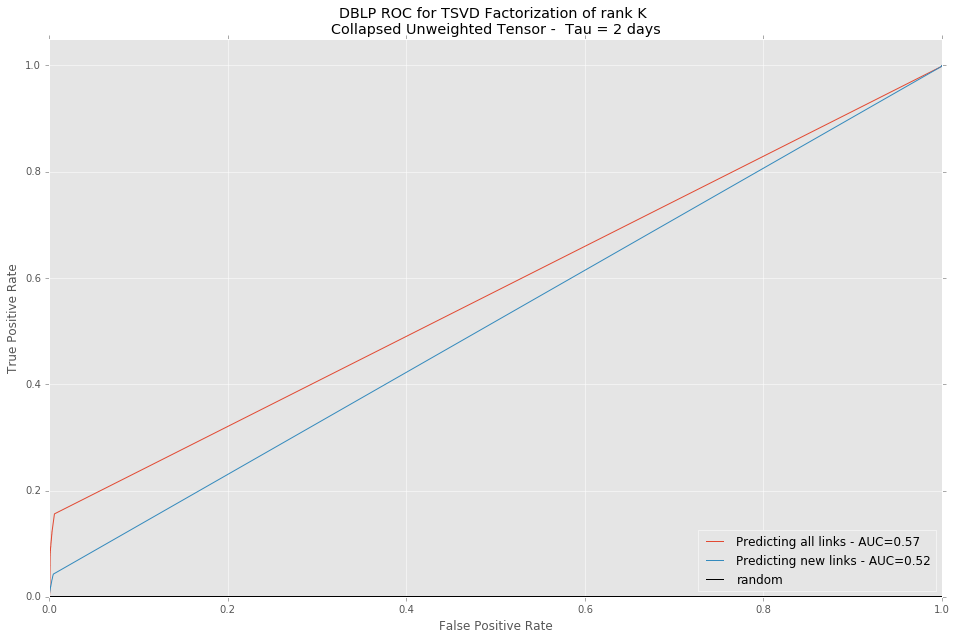

In [25]:
S_test = (1*np.array(T_test[:, :] >= 1))
S = np.zeros((T_train.shape[0], T_train.shape[1]))
S_pred = np.zeros((S.shape[0], S.shape[1]))
S_test_all = np.zeros((S.shape[0], S.shape[1]))

#S_test = np.zeros((CUT.shape[0], CUT.shape[1]))

tau = 2
K_list = [5]
#,5,10,30,50]
FPR = {}
TPR = {}
AUC = {}

S_test = (1*np.array(T_test[:, :] >= 1))

for i in range(2) :
    if i==0 :
        for K_ind in range(len(K_list)):
            K = K_list[K_ind]
            # CP Decomposition
            P, fit, itr, exectimes = cp_als(T_train, K, init='random')
            A, B, C = P.U
            # CP Scoring
            gamma = sum(C[-tau:, :], 0)  # The temporal coefficient
            Sk = sum(map(lambda x: gamma[x]*P.lmbda[x]*Outer([A[:, x], B[:, x]]), range(K)))
            S+= Sk/LA.norm(Sk, 'fro')
        y_test = S_test.flatten()
        y_score = S.flatten()
    else :
        nonz = T_train.nonzero()
        for ind in range(len(nonz[0])):
            i_ind = nonz[0][ind]
            j_ind = nonz[1][ind] 
            S[i_ind, j_ind] = 0
        y_score = S.flatten()
        y_test = S_test.flatten()
            
    # ROC 
    FPR[i], TPR[i], _ = sklearn.metrics.roc_curve(y_test, y_score)
    AUC[i] = sklearn.metrics.roc_auc_score(y_test, y_score)
    
# Plotting the results
plt.clf()
plt.figure(figsize=(16, 10))
plt.plot(FPR[0], TPR[0], label='Predicting all links - AUC={0:0.2f}' .format(AUC[0]))
plt.plot(FPR[1], TPR[1], label= 'Predicting new links - AUC={0:0.2f}'.format(AUC[1]))

plt.axhline(mail_rate, label='random', color='black')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.legend(loc="lower right")
plt.title('DBLP ROC for TSVD Factorization of rank K \nCollapsed Unweighted Tensor -  Tau = %d days' %(tau))
plt.savefig('DBLP TSVD_roc_cut.pdf')   

### Exponential Smoothing  
Precision-Recall for several values of K

In [ ]:
K_list = [1, 5, 10, 30, 50]
#tau_list = [1, 7, 20]
tau_list = [60]
#alpha_list = [0.2, 0.5, 0.8]
alpha_list = [0.3] 

for alpha_ind in range(len(alpha_list)):
    # Choice of alpha
    alpha = alpha_list[alpha_ind]
    for tau_ind in range(len(tau_list)):
        # Choice of tau
        tau = tau_list[tau_ind]

        for K_ind in range(len(K_list)):
            # Choice of K
            K = K_list[K_ind]
            # CP Decomposition
            P, fit, itr, exectimes = cp_als(T_train, K, init='random')
            A, B, C = P.U
            # CP Scoring
            gamma = sum(map(lambda x: ((1 - alpha) ** x) * alpha * C[-x, :], range(t_1 - t_0 - 1)), 0) + \
                    (1 - alpha) ** (t_1 - t_0 + 1) * C[0, :]                                 # Exponential smoothing
            for i in range(Sk.shape[0]) :
                for j in range(Sk.shape[1]) :
                    Sk[i,j] = float(Sk[i,j])
            S += Sk/LA.norm(Sk, 'fro')

y_score = S.flatten()
y_test = (1*np.array(T_test[:, :, 0] >= 1)).flatten()

# Precision-Recall
precision, recall, _ = precision_recall_curve(y_test, y_score)
average_precision = average_precision_score(y_test, y_score)    

# Plotting the results
plt.clf()
plt.figure(figsize=(16, 10))

plt.plot(recall, precision, label='AUC={0:0.2f}' .format(average_precision))

plt.axhline(mail_rate, label='random', color='black')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.legend(loc="lower right")
plt.title('Radoslaw day scale \nPrecision-Recall for CP Factorization of rank K \
              \nCollapsed Weighted Tensor -  Alpha = %.2f - Tau = %d days - Exponential Smoothing' %(alpha, tau))
plt.savefig('Radoslaw day cp_roc_cwt_%.2f_%d Exponential Smoothing.pdf' %(alpha, tau))    